# 1-D Heat Transfer in a Water-Cooled Rocket Nozzle

## James Ho and Jinfay Justin Yuan

In [23]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import numpy as np

In [24]:
def make_system(twg, twc):
    """
    A function that returns a system object with a state called init
    The current system
    
    twg = Hot gas side local wall temperature
    twc = Coolant side local wall temperature
    tco = Temperature of Coolant Liquid (water)
    taw = Temperature of the hot combustion gases (K)
    hg = hot gas side heat transfer co-effficient = 2956
    k = thermal conductivity of Al 6061, W/(m*K)
    thickness = thickness of Al 6061 wall (m)
    hc = coolant side heat transfer co-efficient
    t_0 = intitial time 
    t_end = final time
    
    """
    system = System(init = State(twg = twg, taw = 3000, twc = twc, summ = 0),
                    hg = 2187,
                    k = 167 ,
                    thickness = .00238125,
                    hc = 32369,
                    q =  4905759, 
                    t_0 = 0,
                    t_end = 200,
                    mass = 0.5,
                    c_al = 900,
                    c_water = 4180,
                    dt = 0.01,
                    tco = 363)
    return system

In [25]:
system = make_system(397, 397)

,values
init,twg 397 taw 3000 twc 397 summ ...
hg,2187
k,167
thickness,0.00238125
hc,32369
q,4905759
t_0,0
t_end,200
mass,0.5
c_al,900


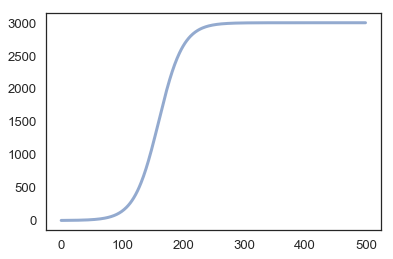

In [97]:
# Function of temperature with respect to time
time = np.linspace(0, 5, 500)
TawTemps = exp(5*time)/((1/3000)*exp(5*time)+1)
plot(range(len(TawTemps)), TawTemps)

In [78]:
def calculate_q(Twg, TawTemp):
    q = system.hg * (TawTemp - Twg);
    return q

In [79]:
def calculate_deltaT(system, q):
    deltaT = (q * system.dt)/(system.mass * system.c_al)
    return deltaT

In [80]:
def calculate_next_Twg(Twg, deltaT):
    return abs(Twg + deltaT)
    

In [81]:
def calculate_twc(system, Twg, q):
    twc = Twg - (q * system.thickness)/system.k
    return twc

In [82]:
def calculate_twc1(system, q):
    twc1 = (q/system.hc) + system.tco 
    return twc1

In [83]:
def calculate_twg1(system, twc1, q):
    twg1 = ((q * system.thickness)/system.k) + twc1
    return twg1

In [99]:
def calculate_tco(system, Twc, q):
    tco = (Twc - (q/system.hc))
    return tco

In [100]:
current_twg = system.init.twg
twgs = []
twcs = []
for i in range(len(TawTemps)):
    q = calculate_q(current_twg, TawTemps[i])
    deltaT = calculate_deltaT(system, q)
    
    twc1 = calculate_twc1(system, q)
    twg1 = calculate_twg1(system, twc1, q)
    q1 = calculate_q(twg1, TawTemps[i])
    
    next_Twg = calculate_next_Twg(twg1, deltaT)
    twg1 = next_Twg
    twcs.append(twc1)
    twgs.append(twg1)
   

    
# Have value Tco, use that to calulate Twc1
    

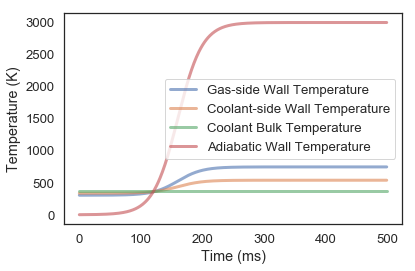

In [103]:
plot(range(len(twgs)), twgs, label='Gas-side Wall Temperature')
plot(range(len(twcs)), twcs, label='Coolant-side Wall Temperature')
plot(np.linspace(system.tco,system.tco,len(twgs)), label='Coolant Bulk Temperature')
plot(range(len(TawTemps)), TawTemps, label='Adiabatic Wall Temperature')
decorate(xlabel='Time (ms)',
             ylabel='Temperature (K)')